In [8]:
import sys
!{sys.executable} -m pip install xlrd

In [1]:
# All imports
import urllib.request as ul
from bs4 import BeautifulSoup
import requests
import re
from datetime import datetime
import datetime
import pandas as pd
import json
import csv
#Stripper dependencies
import sys 
sys.modules["regex"] = __import__("re")
import nltk
nltk.data.path.append(".")
try:
    zyx = nltk.data.find('averaged_perceptron_tagger')
    wrt = nltk.data.find('tokenizers/punkt')
except:
    nltk.download("punkt", download_dir=".")
    nltk.download("averaged_perceptron_tagger", download_dir=".")
from collections import Counter
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
#---
import xlrd
#---
import seaborn as sns

In [2]:
senatorwiki = 'https://en.wikipedia.org/wiki/List_of_current_United_States_Senators'
html = requests.get(senatorwiki)
soup = BeautifulSoup(html.text)
senatortable = soup.find('table',{'class':"sortable"})
rows = senatortable.findAll('tr')

state = []
name = []
party = []
age = []
occupation = []
prev = []
assoff = []
termup = []
res = []

for tr in rows:
    cells=tr.findAll('td')
    alt = tr.findAll('th')
    if len(cells)==9:
        #state.append(cells[0].find(text=True))
        party.append(cells[2].find(text=True))
        occupation.append(cells[4].find(text=True))
        prev.append(cells[5].find(text=True))
        assoff.append(cells[6].find(text=True))
        termup.append(cells[7].find(text=True))
        res.append(cells[8].find(text=True))
        age.append(int(cells[3].find('span','noprint ForceAgeToShow').string[6:-1]))
    if len(cells)==10:
        state.append(cells[0].find(text=True))
        party.append(cells[3].find(text=True))
        occupation.append(cells[5].find(text=True))
        prev.append(cells[6].find(text=True))
        assoff.append(cells[7].find(text=True))
        termup.append(cells[8].find(text=True))
        res.append(cells[9].find(text=True))
        age.append(int(cells[4].find('span','noprint ForceAgeToShow').string[6:-1]))
    if len(alt)==1:
        name.append(alt[0].find(text=True))

c=rows[0].findAll('th')
stac = [el.find(text=True) for el in c]
cats = [el.rstrip() for el in stac]
cats.remove('Portrait')
cats[3] = 'Age'
zcat = dict(zip([str(x) for x in range(len(cats))],cats))

assoff = [x.rstrip() for x in assoff]
assoff = [datetime.datetime.strptime(x,'%B %d, %Y') for x in assoff]
occupation = [x.rstrip() for x in occupation]
termup = [x.rstrip() for x in termup]
termup = [datetime.datetime.strptime(x,'%Y') for x in termup]
states = [x for x in state for i in range(2)]
prev = [x.rstrip() for x in prev]

senators = pd.DataFrame([states,name,party,age,occupation,prev,assoff,termup,res],index=cats).T

today = datetime.date.today()
yrs = pd.Series([senators['Assumed office'][x].year for x in range(len(senators))])

senators['Years served'] = today.year - yrs

#takes the url tails for each senator
url = 'https://justfacts.votesmart.org/candidate/public-statements'
search = 'https://votesmart.org/search?q='
asen ='https://votesmart.org/officials/NA/C/-congressional?chamber=U'
html = requests.get(asen)
soup = BeautifulSoup(html.text)
f = soup.find('h5').find('a')['href'][10:]
soup.findAll('h5')
sencodedict = {line.text:line.find('a')['href'][10:] for line in soup.findAll('h5')}

#updates names to match votesmart
seniority = pd.Series([1 if x%2 else 0 for x in range(1,101)])
senators['Seniority'] = seniority
names = senators['Senator']
surnames = [name.split(' ')[-1] if name.split(' ')[-1] != 'Jr.' else name.split(' ')[-2] for name in names]
senators['Surname'] = surnames
senators = senators.sort_values(by='Surname')

# Alphabetized from votesmart.
sendict = list(sencodedict.keys())
rep = list(sencodedict.keys())
for x in range(len(rep)):
    rep[x] = rep[x].split(' ')
rep = sorted(rep,key=lambda x: x[-1] if (x[-1] != 'Jr.') and (x[-1] != 'III') else x[-2])
for x in range(len(rep)):
    rep[x] = ' '.join(rep[x])
    
senators['Senator'] = rep

alphalist = list(senators['Senator'])
femwiki = 'https://en.wikipedia.org/wiki/Women_in_the_United_States_Senate'
femhtml = requests.get(femwiki)
chickensoup = BeautifulSoup(femhtml.text)
femtable = chickensoup.find('table',{'class':"sortable"})
frows = femtable.findAll('tr')
ttxt = []
for line in femtable.findAll('a'):
    ttxt.append(line.text)
femlist = [x for x in alphalist if x.split(' ')[-1] in [x.split(' ')[-1] for x in ttxt]]
gender = [1 if x not in femlist else 0 for x in alphalist]
senators['Gender'] = gender

party = {}
party[senators['Party'].unique()[0]] = 1
party[senators['Party'].unique()[1]] = -1
party[senators['Party'].unique()[2]] = 0
party_list = [party[x] for x in senators['Party']]
senators['Partynum'] = party_list

In [3]:
# makes dictionary from csv/txt
def webster(file, type=1):
    if type == 1:
        dic = dict(csv.reader(open(file, 'r')))
    else:
        dic = dict([line.split() for line in open(file).read().replace('\t', ' ').split('\n') if len(line) != 0])
    for key in dic:
        dic[key] = float(dic[key])
    return dic

# subsection - dictionaries
valence = webster('valence.csv', type=1)
arousal = webster('arousal.csv', type=1)
dominance = webster('dominance.csv', type=1)
anger = webster('anger-scores.txt', type=0)
sadness = webster('sadness-scores.txt', type=0)
anticipation = webster('anticipation-scores.txt', type=0)
disgust = webster('disgust-scores.txt', type=0)
fear = webster('fear-scores.txt', type=0)
joy = webster('joy-scores.txt', type=0)
surprise = webster('surprise-scores.txt', type=0)
trust = webster('trust-scores.txt', type=0)
humor = pd.read_csv('humor_dataset.csv')
humor_tot = dict(zip(humor['word'], humor['mean']))
humor_M = dict(zip(humor['word'], humor['mean_M']))
humor_F = dict(zip(humor['word'], humor['mean_F']))
humor_young = dict(zip(humor['word'], humor['mean_young']))
humor_old = dict(zip(humor['word'], humor['mean_old']))
selfish = ['I’m', "i'll", 'i’ll', 'me', 'I’ll', 'i’d', "i'd", 'my', 'myself', 'i’m', "i'm", 'i’ve', "i've", 'I', 'i’d’ve', "i'd've", 'i', 'mine']

# create local / global averages
def emoav(emo, selfemo, wrdct):
    emo_len = len(selfemo)
    perc_emo = emo_len / wrdct
    scores = [emo[word] for word in selfemo]
    if len(scores) == 0:
      return 0, 0
    else:
      avg_loc = np.mean(scores)
      avg_glo = avg_loc * perc_emo
      return avg_loc, avg_glo

# opens text file from excel
def bouncer(file):
    workbook = xlrd.open_workbook(file, on_demand=True)
    worksheet = workbook.sheet_by_index(0)
    first_row = [worksheet.cell_value(0,col) for col in range(worksheet.ncols)]

    data = []
    for row in range(1, worksheet.nrows):
        elm = {}
        for col in range(worksheet.ncols):
            elm[first_row[col]]=worksheet.cell_value(row,col)
        data.append(elm)
    return data

# feeds opened file into class
def hostess(data):
    return [Stripper(data[i]['text'], data[i]['index'], data[i]['date'], data[i]['time'], data[i]['person'], data[i]['diagnosis'], data[i]['age'], data[i]['gender']) for i in range(len(data))]

class Stripper:
    """For getting basic info from a file"""
    def __init__(self, text, index, date, time, person, diagnosis, age, gender):
        # imported info from excel
        self.stripped = text
        self.index = index
        self.date = datetime.strptime(date, '%d/%m/%y')
        self.time = time
        self.person = person
        self.diagnosis = diagnosis       
        self.age = age
        self.gender = gender       

        # top-line features
        self.sents = nltk.tokenize.sent_tokenize(self.stripped)
        self.pos_sents = [nltk.pos_tag(self.sents[i].split(' ')) for i in range(len(self.sents))]
        self.num_sents = len(self.sents)
        self.words_tok = nltk.tokenize.word_tokenize(self.stripped)
        self.words_raw = [x for x in self.stripped.split(' ')]
        self.wordcount = len(self.words_raw)
        self.clean_words = [word.lower().replace('.', '').replace(',', '') for word in self.words_raw]
        self.diff_words = set(self.clean_words)
        
        # POS features
        self.pos = nltk.pos_tag(self.words_tok)
        self.counts = Counter(tag for word,tag in self.pos)
        r = 0
        for key in self.counts:
            r += self.counts[key]
        r = r - (self.counts[','] + self.counts['.'])
        # all individual counts are relative to *pos counts* (not wordcounts)
        self.noun = 100 * (self.counts['NN'] + self.counts['NNS'] + self.counts['NNP'] + self.counts['NNPS']) / r
        self.pron = 100 * (self.counts['PRP'] + self.counts['PRP$']) / r
        self.adj = 100 * (self.counts['JJ'] + self.counts['JJR'] + self.counts['JJS']) / r
        self.adv = 100 * (self.counts['RB'] + self.counts['RBR'] + self.counts['RBS']) / r
        self.intj = 100 * (self.counts['UH']) / r
        self.verb = 100 * (self.counts['VB'] + self.counts['VBD'] + self.counts['VBG'] + self.counts['VBN'] + self.counts['VBP'] + self.counts['VBZ']) / r
        self.wh = 100 * (self.counts['WDT'] + self.counts['WP'] + self.counts['WP$'] + self.counts['WRB']) / r
        self.conj = 100 * (self.counts['CC']) / r
        self.prep = 100 * (self.counts['IN'] + self.counts['TO']) / r
        
        # fragments
        self.frag = 0
        self.sent_counts = [Counter(tag for word, tag in sent) for sent in self.pos_sents]
        verbs = {'VB','VBD','VBG','VBN','VBP','VBZ'}
        for sent in self.sent_counts:
            if len(verbs-set(sent.keys())) == len(verbs):
                self.frag += 1
                
        # word frequencies
        self.freq = nltk.FreqDist(word for word in self.clean_words)
        func = open('funcwords.txt').read().translate(str.maketrans("',[]", '    ')).split()
        self.funcs_freq = 100 * sum(self.freq[word] for word in self.freq if word in func) / self.wordcount
        self.rare = [word for word in self.freq if self.freq[word] == 1]
        self.rare_nonfunc = [word for word in self.rare if word not in func]
        self.selfish = sum(self.freq[word] for word in self.freq if word in selfish) / self.num_sents
        
        self.anger = [word for word in self.clean_words if word in anger.keys()]
        self.sadness = [word for word in self.clean_words if word in sadness.keys()]
        self.anticipation = [word for word in self.clean_words if word in anticipation.keys()]
        self.disgust = [word for word in self.clean_words if word in disgust.keys()]
        self.fear = [word for word in self.clean_words if word in fear.keys()]
        self.joy = [word for word in self.clean_words if word in joy.keys()]
        self.surprise = [word for word in self.clean_words if word in surprise.keys()]
        self.trust = [word for word in self.clean_words if word in trust.keys()]
        
        self.valence = [word for word in self.clean_words if word in valence.keys()]
        self.arousal = [word for word in self.clean_words if word in arousal.keys()]
        self.dominance = [word for word in self.clean_words if word in dominance.keys()]

        self.humor = [word for word in self.clean_words if word in humor_tot.keys()]
        
        # emotional strength
        self.al_fear, self.ag_fear = emoav(fear, self.fear, self.wordcount)
        self.al_joy, self.ag_joy = emoav(joy, self.joy, self.wordcount)
        self.al_trust, self.ag_trust = emoav(trust, self.trust, self.wordcount)
        self.al_surprise, self.ag_surprise = emoav(surprise, self.surprise, self.wordcount)
        self.al_disgust, self.ag_disgust = emoav(disgust, self.disgust, self.wordcount)
        self.al_anticipation, self.ag_anticipation = emoav(anticipation, self.anticipation, self.wordcount)
        self.al_anger, self.ag_anger = emoav(anger, self.anger, self.wordcount)
        self.al_sadness, self.ag_sadness = emoav(sadness, self.sadness, self.wordcount)

        self.al_valence, self.ag_valence = emoav(valence, self.valence, self.wordcount)
        self.al_arousal, self.ag_arousal = emoav(arousal, self.arousal, self.wordcount)
        self.al_dominance, self.ag_dominance = emoav(dominance, self.dominance, self.wordcount)

        self.al_humor_tot, self.ag_humor_tot = emoav(humor_tot, self.humor, self.wordcount)
        self.al_humor_M, self.ag_humor_M = emoav(humor_M, self.humor, self.wordcount)
        self.al_humor_F, self.ag_humor_F = emoav(humor_F, self.humor, self.wordcount)
        self.al_humor_young, self.ag_humor_young = emoav(humor_young, self.humor, self.wordcount)
        self.al_humor_old, self.ag_humor_old = emoav(humor_old, self.humor, self.wordcount)

        # sentence and word size
        self.short_sent, self.long_sent = 0, 0
        for sent in self.sents:
            if len(sent.split(' ')) <= 6:
                self.short_sent += 1
            else:
                self.long_sent += 1

        self.short_word, self.long_word = 0, 0
        for word in self.clean_words:
            if len(word) <= 6:
                self.short_word += 1
            else:
                self.long_word += 1
    
    # either gives brief description or returns numpy array
    def bare(self):
        return np.array([self.index, self.person, self.diagnosis, self.age, self.gender, self.time, self.num_sents, self.wordcount, self.noun, self.verb, self.adj, self.adv, self.intj, self.pron, self.wh, self.conj, self.prep, self.short_sent, self.long_sent, self.short_word, self.long_word, self.frag, len(self.diff_words), self.funcs_freq, self.selfish, len(self.rare), (100*len(self.rare_nonfunc)/self.wordcount), (100*len(self.joy)/self.wordcount), (100*len(self.surprise)/self.wordcount), (100*len(self.anticipation)/self.wordcount), (100*len(self.anger)/self.wordcount), (100*len(self.fear)/self.wordcount), (100*len(self.trust)/self.wordcount), (100*len(self.disgust)/self.wordcount), (100*len(self.sadness)/self.wordcount), self.al_fear, self.ag_fear, self.al_joy, self.ag_joy, self.al_trust, self.ag_trust, self.al_surprise, self.ag_surprise, self.al_disgust, self.ag_disgust, self.al_anticipation, self.ag_anticipation, self.al_anger, self.ag_anger, self.al_sadness, self.ag_sadness, self.al_valence, self.ag_valence, self.al_arousal, self.ag_arousal, self.al_dominance, self.ag_dominance, self.al_humor_tot, self.ag_humor_tot, self.al_humor_M, self.ag_humor_M, self.al_humor_F, self.ag_humor_F, self.al_humor_young, self.ag_humor_young, self.al_humor_old, self.ag_humor_old, (100*len(self.humor)/self.wordcount), (100*len(self.valence)/self.wordcount)])
        
# converts arrays into dataframe        
def cashout(arrays):
    temp = [[arrays[i].bare()] for i in range(len(arrays))]
    return pd.DataFrame(np.concatenate(temp), columns=['index', 'person', 'diagnosis', 'age', 'gender', 'time','sents','wordcount','noun','verb','adj','adv','intj','pron','wh','conj','prep','short sent','long sent','short word','long word','frag','# diff','% func words', 'selfish', '# unique', '% unique no func', '% joy', '% surprise', '% anticipation', '% anger', '% fear', '% trust', '% disgust', '% sadness', 'loc fear', 'glb fear', 'loc joy', 'glb joy', 'loc trust', 'glb trust', 'loc surprise', 'glb surprise', 'loc disgust', 'glb disgust', 'loc anticipation', 'glb anticipation', 'loc anger', 'glb anger', 'loc sadness', 'glb sadness', 'loc valence', 'glb valence', 'loc arousal', 'glb arousal', 'loc dominance', 'glb dominance', 'loc humor', 'glb humor', 'loc humor M', 'glb humor M', 'loc humor F', 'glb humor F', 'loc humor young', 'glb humor young', 'loc humor old', 'glb humor old', '% humor', '% VAD'])

# calculates composite measures into the dataframe
def dance(ndf):
    ndf['short/long'] = ndf['short sent'] / ndf['long sent']
    ndf['frag/min'] = ndf['frag'] / ndf['time'] * 60
    ndf['words/min'] = ndf['wordcount'] / ndf['time'] * 60
    ndf['sents/min'] = ndf['sents'] / ndf['time'] * 60
    ndf['words/sent'] = ndf['wordcount'] / ndf['sents']
    ndf['conj/sent'] = ndf['conj'] / ndf['sents']
    ndf['verb/noun'] = ndf['verb'] / ndf['noun']
    ndf['noun/pron'] = ndf['noun'] / ndf['pron']
    ndf['% diff w/func'] = ndf['# diff'] / ndf['wordcount'] * 100
    ndf['% unique w/func'] = ndf['# unique'] / ndf['wordcount'] * 100
    ndf['misc words'] = ndf['wordcount'] - (ndf['noun'] + ndf['verb'] + ndf['adj'] + ndf['adv'] + ndf['pron'] + ndf['intj'] + ndf['wh'] + ndf['prep'] + ndf['conj'])
    ndf['% frag'] = ndf['frag'] / ndf['sents'] * 100
    
# does all of the above in one line with the option of switching to manipulate a single object
def VIP(file, xxx=False):
    temp = cashout(hostess(bouncer(file)))
    dance(temp)
    return temp, hostess(bouncer(file)) 
    
def tablemaker(atts,name,alsoticks='False',time='False'):
    if time == 'False':
        bx = biden[atts].mean()
        tx = trump[atts].mean()
        bxerr = biden[atts].std()/sqrt(len(biden.index))
        txerr = trump[atts].std()/sqrt(len(trump.index))
    else:
        bx = biden_timed[atts].mean()
        tx = trump_timed[atts].mean()
        bxerr = biden_timed[atts].std()/sqrt(len(biden_timed.index))
        txerr = trump_timed[atts].std()/sqrt(len(trump_timed.index))
        

    Z = np.arange(len(atts))
    plt.bar(Z-.1, bx, color='#0015BC', width = .2, label='Biden', yerr=bxerr)
    plt.bar(Z+.1, tx, color='#DE0100', width = .2, label='Trump', yerr=txerr)

    plt.ylabel('Score')
    plt.title(name)
    if alsoticks=='False':
        plt.xticks(Z, tuple(atts))
    else:
        plt.xticks(Z, tuple(alsoticks))
    plt.legend(loc='best')
    plt.figure(figsize=(30,20))
#     plt.savefig(name+'.png')
    plt.show()

In [4]:
# analysis groups
posgrp = ['noun','verb','adj','adv','intj','pron','wh','conj','prep']
lengthgrp = ['short word', 'long word', 'short sent', 'long sent']
humorgrp = ['glb humor', 'glb humor M', 'glb humor F', 'glb humor young', 'glb humor old']
emot_all = ['joy', 'fear', 'sadness', 'anticipation', 'anger', 'disgust', 'trust', 'surprise']
emot_glb = ['glb '+x for x in emot_all]
emot_loc = ['loc '+x for x in emot_all]
ratios = ['short/long','words/sent','verb/noun','noun/pron']
dif_uni = ['% diff w/func','% unique w/func', '% frag']

In [5]:
# SOME THOUGHTS -- I wonder if it would be worthwhile to (later, of course) also do a regional analysis.

# senators data
allsens = pd.read_pickle('allsens_2021.pkl')
females = allsens[allsens['gender']==0]
males = allsens[allsens['gender']==1]

meanage = allsens['age'].mean()
old = allsens[allsens['age']>meanage]
young = allsens[allsens['age']<=meanage]

partydic = pd.Series(senators.Partynum.values,index=senators.Senator).to_dict()
partydic = pd.Series(senators.Partynum.values,index=senators.Senator).to_dict()
allsens['party'] = [partydic[x] for x in allsens['person']]
republicans = allsens[allsens['party']==1]
democrats = allsens[allsens['party']==-1]
independents = allsens[allsens['party']==0]
dems_and_ind = allsens[allsens['party']<1]

# basic features - means
glbemo_allsens, locemo_allsens, selfish_allsens, humor_allsens, pos_allsens, wrdct_allsens, length_allsens, ratios_allsens, unique_allsens = allsens[emot_glb].mean(), allsens[emot_loc].mean(), allsens['selfish'].mean(), allsens[humorgrp].mean(), allsens[posgrp].mean(), allsens['wordcount'].mean(), allsens[lengthgrp].mean(), allsens[ratios].mean(), allsens[dif_uni].mean()

glbemo_females, locemo_females, selfish_females, humor_females, pos_females, wrdct_females, length_females, ratios_females, unique_females = females[emot_glb].mean(), females[emot_loc].mean(), females['selfish'].mean(), females[humorgrp].mean(), females[posgrp].mean(), females['wordcount'].mean(), females[lengthgrp].mean(), females[ratios].mean(), females[dif_uni].mean()

glbemo_males, locemo_males, selfish_males, humor_males, pos_males, wrdct_males, length_males, ratios_males, unique_males = males[emot_glb].mean(), males[emot_loc].mean(), males['selfish'].mean(), males[humorgrp].mean(), males[posgrp].mean(), males['wordcount'].mean(), males[lengthgrp].mean(), males[ratios].mean(), males[dif_uni].mean()

glbemo_old, locemo_old, selfish_old, humor_old, pos_old, wrdct_old, length_old, ratios_old, unique_old = old[emot_glb].mean(), old[emot_loc].mean(), old['selfish'].mean(), old[humorgrp].mean(), old[posgrp].mean(), old['wordcount'].mean(), old[lengthgrp].mean(), old[ratios].mean(), old[dif_uni].mean()

glbemo_young, locemo_young, selfish_young, humor_young, pos_young, wrdct_young, length_young, ratios_young, unique_young = young[emot_glb].mean(), young[emot_loc].mean(), young['selfish'].mean(), young[humorgrp].mean(), young[posgrp].mean(), young['wordcount'].mean(), young[lengthgrp].mean(), young[ratios].mean(), young[dif_uni].mean()

glbemo_republicans, locemo_republicans, selfish_republicans, humor_republicans, pos_republicans, wrdct_republicans, length_republicans, ratios_republicans, unique_republicans = republicans[emot_glb].mean(), republicans[emot_loc].mean(), republicans['selfish'].mean(), republicans[humorgrp].mean(), republicans[posgrp].mean(), republicans['wordcount'].mean(), republicans[lengthgrp].mean(), republicans[ratios].mean(), republicans[dif_uni].mean()

glbemo_democrats, locemo_democrats, selfish_democrats, humor_democrats, pos_democrats, wrdct_democrats, length_democrats, ratios_democrats, unique_democrats = democrats[emot_glb].mean(), democrats[emot_loc].mean(), democrats['selfish'].mean(), democrats[humorgrp].mean(), democrats[posgrp].mean(), democrats['wordcount'].mean(), democrats[lengthgrp].mean(), democrats[ratios].mean(), democrats[dif_uni].mean()

# stds
glbemo_std_allsens, locemo_std_allsens, selfish_std_allsens, humor_std_allsens, pos_std_allsens, wrdct_std_allsens, length_std_allsens, ratios_std_allsens, unique_std_allsens = allsens[emot_glb].std(), allsens[emot_loc].std(), allsens['selfish'].std(), allsens[humorgrp].std(), allsens[posgrp].std(), allsens['wordcount'].std(), allsens[lengthgrp].std(), allsens[ratios].std(), allsens[dif_uni].std()

glbemo_std_females, locemo_std_females, selfish_std_females, humor_std_females, pos_std_females, wrdct_std_females, length_std_females, ratios_std_females, unique_std_females = females[emot_glb].std(), females[emot_loc].std(), females['selfish'].std(), females[humorgrp].std(), females[posgrp].std(), females['wordcount'].std(), females[lengthgrp].std(), females[ratios].std(), females[dif_uni].std()

glbemo_std_males, locemo_std_males, selfish_std_males, humor_std_males, pos_std_males, wrdct_std_males, length_std_males, ratios_std_males, unique_std_males = males[emot_glb].std(), males[emot_loc].std(), males['selfish'].std(), males[humorgrp].std(), males[posgrp].std(), males['wordcount'].std(), males[lengthgrp].std(), males[ratios].std(), males[dif_uni].std()

glbemo_std_old, locemo_std_old, selfish_std_old, humor_std_old, pos_std_old, wrdct_std_old, length_std_old, ratios_std_old, unique_std_old = old[emot_glb].std(), old[emot_loc].std(), old['selfish'].std(), old[humorgrp].std(), old[posgrp].std(), old['wordcount'].std(), old[lengthgrp].std(), old[ratios].std(), old[dif_uni].std()

glbemo_std_young, locemo_std_young, selfish_std_young, humor_std_young, pos_std_young, wrdct_std_young, length_std_young, ratios_std_young, unique_std_young = young[emot_glb].std(), young[emot_loc].std(), young['selfish'].std(), young[humorgrp].std(), young[posgrp].std(), young['wordcount'].std(), young[lengthgrp].std(), young[ratios].std(), young[dif_uni].std()

glbemo_std_republicans, locemo_std_republicans, selfish_std_republicans, humor_std_republicans, pos_std_republicans, wrdct_std_republicans, length_std_republicans, ratios_std_republicans, unique_std_republicans = republicans[emot_glb].std(), republicans[emot_loc].std(), republicans['selfish'].std(), republicans[humorgrp].std(), republicans[posgrp].std(), republicans['wordcount'].std(), republicans[lengthgrp].std(), republicans[ratios].std(), republicans[dif_uni].std()

glbemo_std_democrats, locemo_std_democrats, selfish_std_democrats, humor_std_democrats, pos_std_democrats, wrdct_std_democrats, length_std_democrats, ratios_std_democrats, unique_std_democrats = democrats[emot_glb].std(), democrats[emot_loc].std(), democrats['selfish'].std(), democrats[humorgrp].std(), democrats[posgrp].std(), democrats['wordcount'].std(), democrats[lengthgrp].std(), democrats[ratios].std(), democrats[dif_uni].std()

# Averaging each senator
sensavg = []
for i in range(100):
    sensavg.append(allsens[allsens['person']==sendict[i]].mean())
sensavg = pd.DataFrame(sensavg)
sensavg['person'] = [x for x in range(100)]

sensstd = []
for i in range(100):
    sensstd.append(allsens[allsens['person']==sendict[i]].mean())
sensstd = pd.DataFrame(sensstd)
sensstd['person'] = [x for x in range(100)]

In [6]:
youngest = int(sensavg['age'].min())
youngest

41

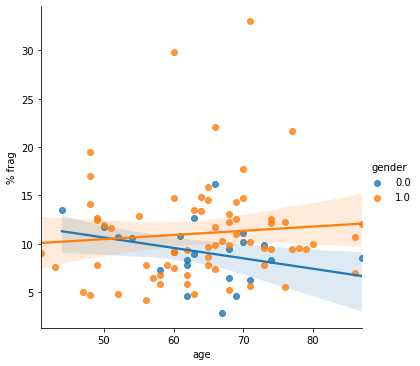

In [11]:
sensavg['age_bin'] = pd.cut(sensavg['age'], np.arange(int(sensavg['age'].min()),int(sensavg['age'].max()),step=20))
g = sns.lmplot(
    data=sensavg,
    x='age',
    y='% frag',
    hue='gender')

In [11]:
senators.Years_served

AttributeError: 'DataFrame' object has no attribute 'Years_served'